# Replicate AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE

## 1. Image data loading and preprocessing  

In [ ]:
# pip install
!pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install -q torchinfo

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import datasets, transforms
from torchinfo import summary
from torch.utils.data import DataLoader


device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Set seeds to ensure reproducibility
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

#### 1.1 Load the data from google drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify the path to your file in Google Drive
file_path = '/content/drive/MyDrive/vegetable_images'


# Setup directory path to train and test images
train_dir = file_path + "/train"
test_dir = file_path + "/test"

Mounted at /content/drive


In [ ]:
train_dir

'/content/drive/MyDrive/vegetable_images/train'

In [ ]:
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [ ]:
# Set the batch size
BATCH_SIZE = 64

# Create data loaders
train_data = datasets.ImageFolder(train_dir, transform=manual_transforms)
test_data = datasets.ImageFolder(test_dir, transform=manual_transforms)

# Get class names
class_names = train_data.classes

# Turn images into data loaders
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [ ]:
class_names

['Potato', 'Radish', 'Tomato']

In [ ]:
train_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79c13e0cf940>,
 ['Potato', 'Radish', 'Tomato'])

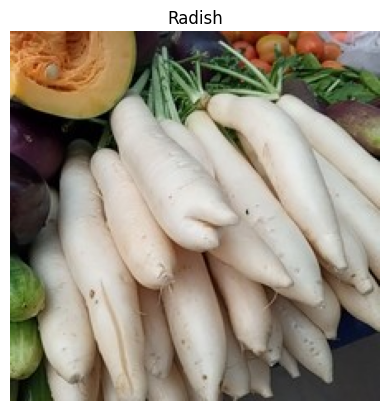

In [ ]:
# Check the images and label
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

# Plot the image
plt.imshow(image.permute(1, 2, 0)) # image_permuted -> (Height, Width, Color Channels)
plt.title(class_names[label])
plt.axis(False);

####1.2 Convert the 2D input image into a 1D sequential data

In [ ]:
# Patch embedding - split data into patches using Conv2d

# We want to create patches whose size is 16*16
PATCH_SIZE = 16

# Total number of features per patch
original_channels = image.shape[0]
num_features = PATCH_SIZE**2 * original_channels


In [ ]:
class PatchEmbedding(nn.Module):
  """
  Turn a 2D image input data into 1D sequence learnable embedding vector

  Args:
        in_channels: Number of color channels in the input image
        patch_size: Size of a single patch
        embedding_dim: Size of embedding per patch

  """

  def __init__(self,
               in_channels:int=3,
               patch_size:int=16):
      super().__init__()

      self.patch_size = patch_size
      self.embedding_dim = patch_size**2 * in_channels

      # Create a Conv2d layer to divide an image into multiple patches
      self.patcher = nn.Conv2d(in_channels=in_channels,
                              out_channels=self.embedding_dim,
                              kernel_size=patch_size,
                              stride=patch_size,
                              padding=0)


      # Create a Flatten layer to convert the 2D patch embedding to a single dimension sequence
      self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):
    image_size = x.shape[-1]
    assert image_size % self.patch_size == 0, "Image size must be divisible by patch size"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    return x_flattened.permute(0, 2, 1)


In [ ]:
set_seeds()

patcher = PatchEmbedding()

image_patch_embedding = patcher(image.unsqueeze(0))

print(f"the image shape is converted from {image.unsqueeze(0).shape} to {image_patch_embedding.shape}")

the image shape is converted from torch.Size([1, 3, 224, 224]) to torch.Size([1, 196, 768])


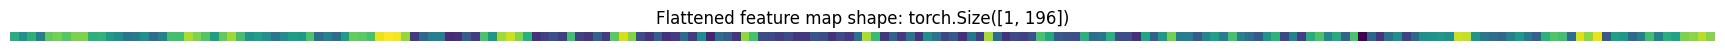

In [ ]:
# Visualize a single flattened feature map

single_flattened_feature_map = image_patch_embedding[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

## Implement ViT

#### 2.1: Create MultiheadSelfAttentionBlock

In [ ]:
class MultiheadSelfAttentionBlock(nn.Module):
  """
  Create a multi-head self attention block
  """

  def __init__(self,
               embedding_dim: int,
               num_heads: int,
               attn_dropout: float):
    super().__init__()

    # Create a layer normalization layer, which doesn't change the embedding vector shape
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create a multi head attention layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 dropout=attn_dropout)

  def forward(self, x):
    x = self.layer_norm(x)

    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)

    return attn_output

#### 2,2 Create Multilayer Perceptron

In [ ]:
class MultilayerPerceptronBlock(nn.Module):
  """
  Create a multilayer perceptron block
  """

  def __init__(self,
               embedding_dim: int,
               mlp_size: int,
               mlp_dropout: float):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=mlp_dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=mlp_dropout),
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)

    return x


#### 2.3 Create TransformerEncoderBlock

In [ ]:
class TransformerEncoderBlock(nn.Module):
  """
  Create a Transformer Encoder
  """

  def __init__(self,
               embedding_dim: int,
               num_heads: int,
               mlp_size: int,
               attn_dropout: float,
               mlp_dropout: float):
    super().__init__()

    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    self.mlp_block = MultilayerPerceptronBlock(embedding_dim=embedding_dim,
                                               mlp_size=mlp_size,
                                               mlp_dropout=mlp_dropout)


  def forward(self, x):
    x = self.msa_block(x) + x # Residule connection
    x = self.mlp_block(x) + x # Residule connection

    return x


#### 2.4 Create ViT

In [ ]:
class ViT(nn.Module):
  """
  """

  def __init__(self,
               image_size:int=224,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dropout:float=0.1,
               num_heads:int=12, # the value is 12 in the paper
               attn_dropout:float=0,
               mlp_size:int=3072, # the value is 3072 in the paper
               mlp_dropout:float=0.1,
               num_transformer_layers:int=12, # the value is 12 in the paper
               num_classes:int=3):
    super().__init__()

    # Check if the image size is divisble by the patch size
    assert image_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {image_size}, patch size: {patch_size}."

    self.embedding_dim = patch_size**2 * in_channels

    self.num_patches = (image_size // patch_size)**2

    # Create class_token embedding
    self.class_token = nn.Parameter(data=torch.rand(1, 1, self.embedding_dim),
                                    requires_grad=True)

    # Create position embedding
    self.position_embedding = nn.Parameter(data=torch.rand(1, (self.num_patches+1), self.embedding_dim),
                                           requires_grad=True)

    # Create embedding dropout
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # 5. Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size)

    # Create Transformer Encoder
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=self.embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       attn_dropout=attn_dropout,
                                                                       mlp_dropout=mlp_dropout)
    for _ in range(num_transformer_layers)])


    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=self.embedding_dim),
        nn.Linear(in_features=self.embedding_dim,
                  out_features=num_classes)
    )


  def forward(self, x):

    # Get batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

    # Create patch embedding (equation 1)
    x = self.patch_embedding(x)

    # Concat class embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1)

    # Add position embedding to patch embedding (equation 1)
    x = self.position_embedding + x

    # Run embedding dropout (Appendix B.1)
    x = self.embedding_dropout(x)

    # Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
    x = self.transformer_encoder(x)

    # Put 0 index logit through classifier (equation 4)
    x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

    return x


## 3. Train ViT model using a small dataset

In [ ]:
set_seeds()

# Create a random tensor with same shape as a single image for quick testing the model
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-1.0359,  0.1640,  0.3743]], grad_fn=<AddmmBackward0>)

#### 3.1 Training methods setup

In [ ]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

  model.to(device)
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                         dataloader=train_dataloader,
                                         loss_fn=loss_fn,
                                         optimizer=optimizer,
                                         device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # Forward pass
      y_pred = model(X)

      # Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # Optimizer zero grad
      optimizer.zero_grad()

      # Loss backward
      loss.backward()

      # Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across the batch
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # Forward pass
          test_pred_logits = model(X)

          # Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

###3.2 Set up optimizers, loss function and start training

In [ ]:
# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3)

# Typical loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()



In [ ]:
results = train(model=vit,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7026 | train_acc: 0.3311 | test_loss: 1.1172 | test_acc: 0.3750
Epoch: 2 | train_loss: 1.1165 | train_acc: 0.3404 | test_loss: 1.1156 | test_acc: 0.3125
Epoch: 3 | train_loss: 1.1161 | train_acc: 0.3180 | test_loss: 1.1160 | test_acc: 0.3750
Epoch: 4 | train_loss: 1.1171 | train_acc: 0.3295 | test_loss: 1.1314 | test_acc: 0.3125
Epoch: 5 | train_loss: 1.1068 | train_acc: 0.3414 | test_loss: 1.1076 | test_acc: 0.3750
Epoch: 6 | train_loss: 1.1084 | train_acc: 0.3425 | test_loss: 1.1149 | test_acc: 0.3125
Epoch: 7 | train_loss: 1.1023 | train_acc: 0.3383 | test_loss: 1.0972 | test_acc: 0.3750
Epoch: 8 | train_loss: 1.1051 | train_acc: 0.3295 | test_loss: 1.0960 | test_acc: 0.3750
Epoch: 9 | train_loss: 1.1007 | train_acc: 0.3248 | test_loss: 1.0954 | test_acc: 0.3750
Epoch: 10 | train_loss: 1.0998 | train_acc: 0.3263 | test_loss: 1.0969 | test_acc: 0.3750


###3.3 Predict customer images

In [ ]:
from typing import List, Tuple

from PIL import Image

def inference(image_path: str,
              model: torch.nn.Module,
              transformer: torchvision.transforms,
              device: torch.device):
  img = Image.open(custom_image_path)

  # Put the model in eval mode
  model.eval()

  with torch.inference_mode():
    # Transform and add an extra dimension to image, and add it to the target device
    transformed_image = manual_transforms(img).unsqueeze(dim=0).to(device)

    # Make a prediction on image with an extra dimension and send it to the target device
    target_image_pred = model(transformed_image)

  # Convert logits to prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  print(target_image_pred_probs)

  # Convert prediction probabilities to prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot image with predicted label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);

tensor([[0.3252, 0.3305, 0.3443]], device='cuda:0')


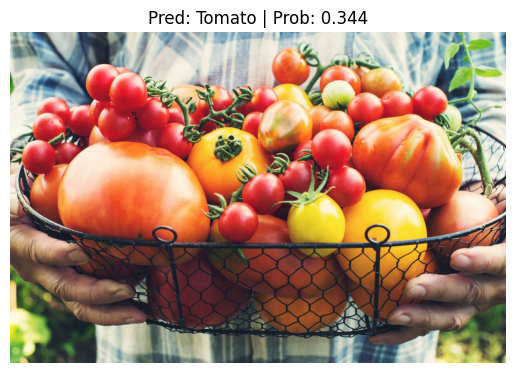

In [ ]:
custom_image_path = file_path + "/customer_tomato.jpeg"

inference(custom_image_path, vit, manual_transforms, device)



In [ ]:
# save the model
from pathlib import Path

def save_model(model: torch.nn.Module,
               model_name: str,
               target_path: str):

  target_dir_path = Path(target_path)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [ ]:
# Save above model (Although it's not good at all. Usually we save the model with the best accuracy during an iteration of different models)

target_path = "MyDrive/demo-vit"
model_name = "03_vit.pth"

save_model(vit, model_name, target_path)

# We can also leverage checkpoint to save model during the training, not implemented here.


[INFO] Saving model to: MyDrive/demo-vit/03_vit.pth


In [ ]:
# Retrieve the model from the Google Drive
retrieved_vit = ViT()
retrieved_vit.load_state_dict(torch.load("MyDrive/demo-vit/03_vit.pth"))

retrieved_vit.to(device)

tensor([[0.3252, 0.3305, 0.3443]], device='cuda:0')


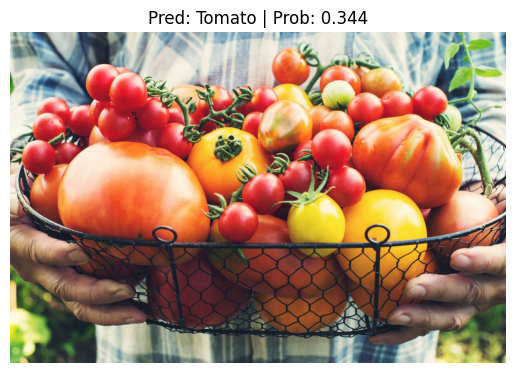

In [ ]:
# Predict the customer image

inference(custom_image_path, retrieved_vit, manual_transforms, device)

## 4. Using pretrained ViT model to fine tune on a small dataset.

####4.1 Load the updated pre-trained ViT.

In [ ]:
# Get weights from pretrained ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup a ViT model instance with above weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters during training process
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Get transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()


####4.2 Predict customer image directly

In [ ]:
# Change the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

tensor([[0.4054, 0.1541, 0.4405]], device='cuda:0')


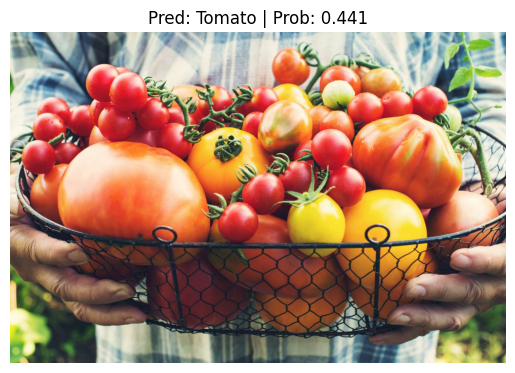

In [ ]:
# Before training, predict the customer image
custom_image_path = file_path + "/customer_tomato.jpeg"
inference(custom_image_path, pretrained_vit, pretrained_vit_transforms, device)

In [ ]:
# # Load a small dataset
# file_path_small = '/content/drive/MyDrive/small_vegetable_images'


# # Setup directory path to train and test images
# train_dir_small = file_path_small + "/train"
# test_dir_small = file_path_small + "/test"

####4.3 Fine tune the pre-trained ViT with a small dataset

In [ ]:
# Create data loaders
train_data_pretrained = datasets.ImageFolder(train_dir, transform=pretrained_vit_transforms)
test_data_pretrained = datasets.ImageFolder(test_dir, transform=pretrained_vit_transforms)

# Get class names
class_names_pretrained = train_data_pretrained.classes

# Turn images into data loaders
train_dataloader_pretrained = DataLoader(
    train_data_pretrained,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)
test_dataloader_pretrained = DataLoader(
    test_data_pretrained,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [ ]:
# Create optimizer and loss function
optimizer_pretrained = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)  # This is a basic optimizer, and can be modified to complicated approaches such as learning rate scheduling and early stopping.
loss_fn_pretrained = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT (feature extractor)
set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                              train_dataloader=train_dataloader_pretrained,
                              test_dataloader=test_dataloader_pretrained,
                              optimizer=optimizer_pretrained,
                              loss_fn=loss_fn_pretrained,
                              epochs=10,
                              device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0587 | train_acc: 0.9889 | test_loss: 0.0081 | test_acc: 1.0000
Epoch: 2 | train_loss: 0.0056 | train_acc: 0.9997 | test_loss: 0.0036 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.0025 | train_acc: 1.0000 | test_loss: 0.0021 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.0015 | train_acc: 1.0000 | test_loss: 0.0015 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0010 | train_acc: 1.0000 | test_loss: 0.0012 | test_acc: 1.0000
Epoch: 6 | train_loss: 0.0007 | train_acc: 1.0000 | test_loss: 0.0009 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.0005 | train_acc: 1.0000 | test_loss: 0.0007 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0004 | train_acc: 1.0000 | test_loss: 0.0006 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.0003 | train_acc: 1.0000 | test_loss: 0.0005 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0003 | train_acc: 1.0000 | test_loss: 0.0004 | test_acc: 1.0000


#### 4.4: Predict a customer image using fine tuned ViT

tensor([[4.5367e-02, 9.1759e-04, 9.5372e-01]], device='cuda:0')


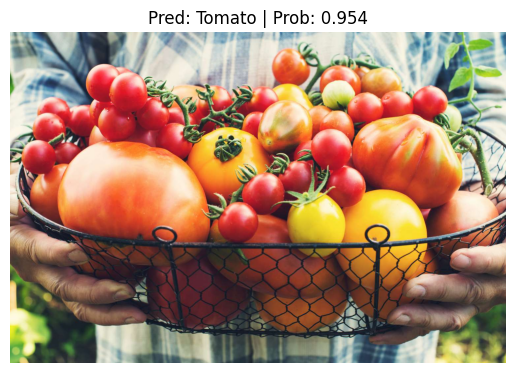

In [ ]:
inference(custom_image_path, pretrained_vit, pretrained_vit_transforms, device)
